# Analysis of Chest X-Ray images

Neural networks have revolutionised image processing in several different domains. Among these is the field of medical imaging. In the following notebook, we will get some hands-on experience in working with Chest X-Ray (CXR) images.

The objective of this exercise is 2 fold. 

 1. To identify images where an "effusion" is present. This is a classification problem, where we will be dealing with two classes - 'effusion' and 'nofinding'. Here, the latter represents a "normal" X-ray image. This same methodology can be used to spot various other illnesses that can be detected via a chest x-ray. For the scope of this demonstration, we will specifically deal with "effusion".
 2. To prepare a training script to run in a distributed ML environment


## 1. Data Pre-processing

Our data is in the form of grayscale (black and white) images of chest x-rays. To perform our classification task effectively, we need to perform some pre-processing of the data.

First, we load all the relevant libraries.

In [1]:
# !pip install opencv-python
# !pip install matplotlib
# !pip install tensorflow==2.4.1
# !pip install keras==2.3.1
# !pip install 'h5py<3.0.0'
# !pip install pydot

In [2]:
import cv2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings

import azureml
from azureml.core import Experiment
from azureml.core import Workspace, Run
from azureml.core import Environment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.telemetry import set_diagnostics_collection
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
from azureml.core.authentication import InteractiveLoginAuthentication

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from platform import python_version
from keras.utils import plot_model

import random as rn
import tensorflow as tf
import keras as k

rn.seed(30)
np.random.seed(30)
tf.compat.v1.random.set_random_seed(30)
print(python_version())
set_diagnostics_collection(send_diagnostics=False)
print(tf.__version__)
warnings.simplefilter('ignore')


3.8.1
2.3.0


Using TensorFlow backend.


Login and configure Azure ML Workspace

In [3]:
interactive_auth = InteractiveLoginAuthentication(tenant_id="72f988bf-86f1-41af-91ab-2d7cd011db47")
ws = Workspace(subscription_id="925a5ad8-a21a-48c0-92a2-5a8a2a4dfc46",
               resource_group="ml-workbench",
               workspace_name="ml-workbench-eu",
               auth=interactive_auth)

In [4]:
# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


In [5]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

Workspace name: ml-workbench-eu
Azure region: eastus
Subscription id: 925a5ad8-a21a-48c0-92a2-5a8a2a4dfc46
Resource group: ml-workbench


Download the dataset from google drive onto the Azure Compute Machine. 

In [6]:
from azureml.core.dataset import Dataset

web_paths = [
                'https://mlworkbencheu2397988138.blob.core.windows.net/datasets/data.zip'
            ]
dataset = Dataset.File.from_files(path=web_paths)

Registering the dataset so that it can be used across workspace

In [7]:
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'effusion-dataset')
    dataset_registered = True
except:
    print("The dataset effusion-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'effusion-dataset',
                               description='training and test dataset',
                               create_new_version=True)
# list the files referenced by dataset
dataset.to_path()

['/data.zip']

Configure Compute Target

Note: We can also create compute target here if it does not exist. Saving time by pre-creating the compute target. 
In the first few samples we will use a single node, later we will use a cluster for distributed training.

In [8]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-instance-small"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
except ComputeTargetException:
    print('Compute Target does not exist...')

In [9]:
dataset.download('/tmp/data/', overwrite=True)

['/tmp/data/data.zip']

In [10]:
!mkdir -p /var/tmp/effusion
!cp /tmp/data/data.zip /var/tmp/effusion
!unzip -qq -o /var/tmp/effusion/data.zip -d /var/tmp/effusion/

In [11]:
DATASET_PATH = '/var/tmp/effusion/data'

# There are two classes of images that we will deal with
disease_cls = ['effusion', 'nofinding']

print('Number of effusion images..',len([name for name in os.listdir(os.path.join(DATASET_PATH, 'effusion'))]))
print('Number of No finding images..',len([name for name in os.listdir(os.path.join(DATASET_PATH, 'nofinding'))]))

Number of effusion images.. 107
Number of No finding images.. 1000


Next, we read the "effusion" and "nofinding" images.

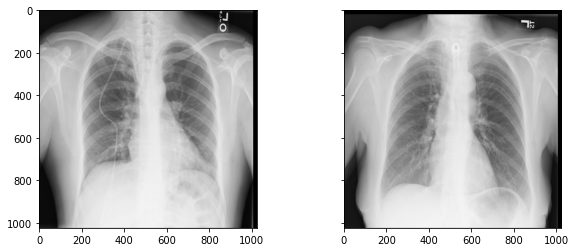

In [12]:
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = cv2.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = cv2.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey=True)
f.set_figwidth(10)
    
axes[0].imshow(effusion, cmap='gray')
axes[1].imshow(normal, cmap='gray')

In [13]:
effusion.shape, normal.shape

((1024, 1024, 3), (1024, 1024, 3))

(256, 256, 3)


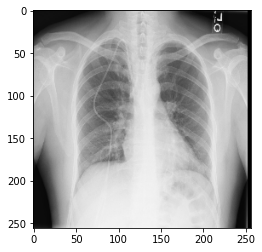

In [14]:
resized_img = cv2.resize(effusion, (256,256), interpolation = cv2.INTER_NEAREST)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
print(resized_img.shape)

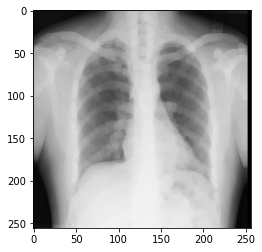

In [15]:
kernel = np.ones((5,5),np.uint8)
opened = cv2.morphologyEx(resized_img, cv2.MORPH_OPEN, kernel)
plt.imshow(opened)

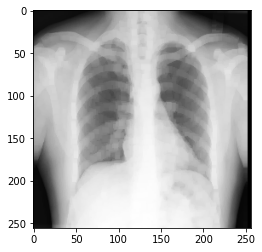

In [16]:
# Normalized Image
normalizedImg = np.zeros((256, 256))
plt.imshow(cv2.normalize(opened, normalizedImg, 0, 255, cv2.NORM_MINMAX))

### Data Augmentation ###

Now that we have read the images, the next step is data augmentation.

In [17]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=10,
    width_shift_range=0,
    height_shift_range=0,
    vertical_flip=False,)

def preprocess_img(img, mode):
    normalizedImg = np.zeros((256, 256))
    resized_img = cv2.resize(img, (256,256))
    normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)[:,:,np.newaxis]
    if mode == 'train':
        if np.random.randn() > 0:
            kernel = np.ones((5,5),np.uint8)
            opened = cv2.morphologyEx(normalized_img, cv2.MORPH_OPEN, kernel)[:,:,np.newaxis]
            normalized_img = datagen.random_transform(opened)
    return normalized_img

Before pre processing image....
/var/tmp/effusion/data/effusion/00007633_000.png
shape.. (1024, 1024)


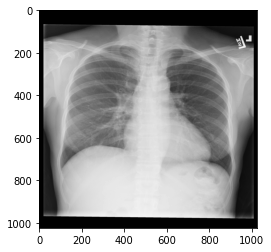

In [18]:
img_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
imgs = glob.glob(img_path)
image_id = 8
print('Before pre processing image....')
print(imgs[image_id])
img = cv2.imread(imgs[image_id], cv2.IMREAD_GRAYSCALE)
print('shape..', img.shape)
plt.imshow(img,cmap='gray')

After pre processing image....
shape.. (256, 256)


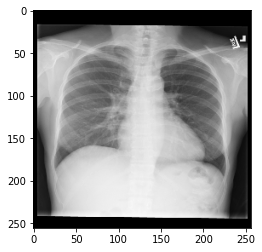

In [19]:
processed_img = preprocess_img(img[:, :, np.newaxis], 'train')
print('After pre processing image....')
print('shape..',processed_img[:,:,0].shape)
plt.imshow(processed_img[:,:,0],cmap='gray')

## 2. Model building

Let us build a CNN model.

In [20]:
from tensorflow.keras.metrics import AUC

img_channels = 1
img_rows = 256
img_cols = 256
nb_classes = 1

cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_rows,img_cols,img_channels)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu',))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Conv2D(128, (3, 3), padding='same', activation='relu',))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(Dense(512))
cnn.add(Dense(nb_classes,activation='sigmoid'))
cnn.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

In [21]:
import numpy as np

class AugmentedDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, mode='train', ablation=None, disease_cls = ['nofinding', 'effusion'], 
                 batch_size=32, dim=(256, 256), n_channels=1, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = {}
        self.list_IDs = []
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
        
            
        self.n_channels = n_channels
        self.n_classes = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        
        delete_rows = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(ID, cv2.IMREAD_GRAYSCALE)
            img = img[:, :, np.newaxis]
            if img.shape[:3] == (1024, 1024,1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.labels[ID]
            else:
                delete_rows.append(i)
                continue
        X = np.delete(X, delete_rows, axis=0)
        y = np.delete(y, delete_rows, axis=0)
        return X, y

## 3. Ablation Run

An ablation run is when you systematically modify certain parts of the input, in order to observe the equivalent change in the input.

For the following section, we'll be using the Data Generator concept that you previously worked on.

In [22]:
training_generator = AugmentedDataGenerator('train', ablation=50)
validation_generator = AugmentedDataGenerator('val', ablation=50)

cnn.fit(training_generator, epochs=1, validation_data=validation_generator)

13/13 [==============================] - 8s 599ms/step - loss: 0.3514 - accuracy: 0.8462 - auc: 0.4626 - val_loss: 0.2870 - val_accuracy: 0.9167 - val_auc: 0.5497


In [23]:
training_generator = AugmentedDataGenerator('train', ablation=5)

cnn.fit(training_generator, epochs=5, validation_data=None)

Epoch 1/5
1/1 [==============================] - 0s 87ms/step - loss: 0.3005 - accuracy: 0.9062 - auc: 0.6954
Epoch 2/5
1/1 [==============================] - 0s 87ms/step - loss: 0.3001 - accuracy: 0.9062 - auc: 0.7299
Epoch 3/5
1/1 [==============================] - 0s 88ms/step - loss: 0.3093 - accuracy: 0.9062 - auc: 0.5977
Epoch 4/5
1/1 [==============================] - 0s 86ms/step - loss: 0.3199 - accuracy: 0.9062 - auc: 0.4253
Epoch 5/5
1/1 [==============================] - 0s 86ms/step - loss: 0.3150 - accuracy: 0.9062 - auc: 0.5460


In [24]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import *

class roc_callback(Callback):
    
    def on_train_begin(self, logs={}):
        logs['val_auc'] = 0

    def on_epoch_end(self, epoch, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print ('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [25]:
training_generator = AugmentedDataGenerator('train', ablation=20)
validation_generator = AugmentedDataGenerator('val', ablation=20)

auc_logger = roc_callback()

history = cnn.fit(training_generator, epochs=5, validation_data=validation_generator, callbacks=[auc_logger])

Epoch 1/5
5/5 [==============================] - ETA: 0s - loss: 0.3192 - accuracy: 0.9000 - auc: 0.6302
Val AUC for epoch0: 0.5517241379310345
5/5 [==============================] - 4s 705ms/step - loss: 0.3192 - accuracy: 0.9000 - auc: 0.6302 - val_loss: 0.2546 - val_accuracy: 0.9375 - val_auc: 0.4500
Epoch 2/5
5/5 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.9062 - auc: 0.6179
Val AUC for epoch1: 0.45977011494252873
5/5 [==============================] - 3s 596ms/step - loss: 0.3027 - accuracy: 0.9062 - auc: 0.6179 - val_loss: 0.3173 - val_accuracy: 0.9062 - val_auc: 0.5345
Epoch 3/5
5/5 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.9000 - auc: 0.6721
Va

## 4. Final Run

In [26]:
import matplotlib.pyplot as plt
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    
    axes[1].plot(history.history['accuracy'])   
    axes[1].plot(history.history['val_accuracy'])
    axes[1].legend(['accuracy','val_accuracy'])

    axes[2].plot(history.history['auc'])   
    axes[2].plot(history.history['val_auc'])
    axes[2].legend(['auc','val_auc'])


After deeply examining our data and building some preliminary models, we are finally ready to build a model that will perform our prediction task.

In [27]:
from keras import backend as kb
class DecayLR(tf.keras.callbacks.Callback):
    def __init__(self, base_lr=0.01, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        kb.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(kb.get_value(self.model.optimizer.lr))
        kb.set_value(self.model.optimizer.lr, new_lr)

In [28]:
training_generator = AugmentedDataGenerator('train', ablation=None)
validation_generator = AugmentedDataGenerator('val', ablation=None)

class_weight = {0: 1., 1: 10.}
auc_logger = roc_callback()
os.makedirs('models', exist_ok=True)
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
ES = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, verbose=1, mode='max')
decay = DecayLR()

history = cnn.fit(training_generator, epochs=10, validation_data=validation_generator, callbacks=[auc_logger, decay, ES, checkpoint], class_weight=class_weight)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 1.3503 - accuracy: 0.3935 - auc: 0.5439
Val AUC for epoch0: 0.6529069767441861

Epoch 00001: val_auc improved from -inf to 0.59515, saving model to models/best_model.hdf5
27/27 [==============================] - 21s 790ms/step - loss: 1.3503 - accuracy: 0.3935 - auc: 0.5439 - val_loss: 0.7256 - val_accuracy: 0.1719 - val_auc: 0.5951
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 1.2535 - accuracy: 0.5359 - auc: 0.6677
Val AUC for epoch1: 0.6484033613445378

Epoch 00002: val_auc improved from 0.59515 to 0.68765, saving model to models/best_model.hdf5
27/27 [==============================] - 21s 790ms/step - loss: 1.2535 - accuracy: 0.5359 - auc: 0.6677 - val_loss: 0.6286 - val_accuracy: 0.8125 - val_auc: 0.6876

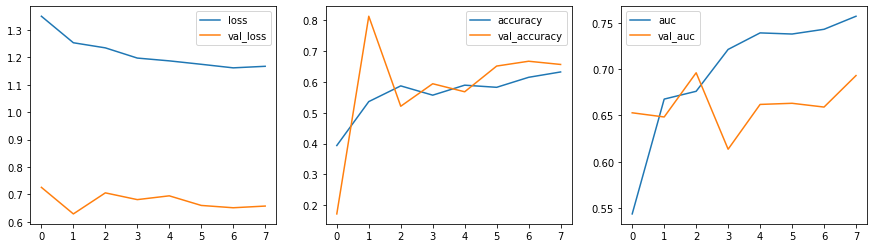

In [29]:
plot(history)

## 5. Making a Prediction

In [30]:
from tensorflow.keras.models import load_model
cnn.load_weights('models/best_model.hdf5')

/var/tmp/effusion/data/effusion/00007520_000.png


array([[0.6451314]], dtype=float32)

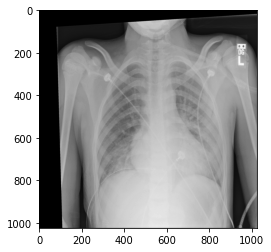

In [31]:
validation_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
validations = glob.glob(validation_path)
image_id = np.random.randint(0, len(validations))
print(validations[image_id])
validation = cv2.imread(validations[image_id], cv2.IMREAD_GRAYSCALE)
plt.imshow(validation,cmap='gray')
img = preprocess_img(validation[:, :, np.newaxis], 'validation')
cnn.predict(img[np.newaxis,:])

### 6. Submitting Experiments using ScriptRunConfig

From the above experiements we find out the best model and create a training script

In [32]:
import os
from azureml.core import ScriptRunConfig
import shutil
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

project_folder = './effusion_detector'
os.makedirs(project_folder, exist_ok=True)
shutil.copy('effusion_detector.py', project_folder)

experiment_name = 'tf-effusion-detector'
experiment = Experiment(ws, name=experiment_name)

tf_env = Environment("tensorflow-2.3-gpu")
packages = CondaDependencies.create(conda_packages=['scikit-learn','pip'],
                                    pip_packages=['azureml-defaults', 'opencv-python==3.3.0.9', 'matplotlib', 'keras<=2.3.1', 'azureml-sdk', 'azureml-widgets', 'tensorflow'])
tf_env.python.conda_dependencies = packages

args = ['--data-folder', dataset.as_mount(), '--epochs', 20]
compute_target = ComputeTarget(workspace=ws, name='gpu-instance-small')
src = ScriptRunConfig(source_directory=project_folder,
                      script='effusion_detector.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env)

run = experiment.submit(src)
print(run)
run.get_details()


Run(Experiment: tf-effusion-detector,
Id: tf-effusion-detector_1621070631_6749fe85,
Type: azureml.scriptrun,
Status: Preparing)


{'runId': 'tf-effusion-detector_1621070631_6749fe85',
 'target': 'gpu-instance-small',
 'status': 'Preparing',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '6c55bc3c-66c0-47d9-8cc9-0bd994aa6443',
  'azureml.git.repository_uri': 'https://github.com/sriksmachi/octopus.git',
  'mlflow.source.git.repoURL': 'https://github.com/sriksmachi/octopus.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '5a3b2bc34cc8a288751e78d6d790da39db664fbb',
  'mlflow.source.git.commit': '5a3b2bc34cc8a288751e78d6d790da39db664fbb',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [{'dataset': {'id': '936fc596-dc32-48e8-8ba5-dcbc3bf2b310'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__6c7da753', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'effusion_detector.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumptionConfig:inp

In [33]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…

### Distributed Machine Learning using Horovod

In [37]:
import os
from azureml.core import ScriptRunConfig
import shutil
from azureml.core import Experiment
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.widgets import RunDetails
from azureml.core.runconfig import MpiConfiguration

project_folder = './effusion_detector-distributed'
os.makedirs(project_folder, exist_ok=True)
shutil.copy('effusion_detector_distributed.py', project_folder)

experiment_name = 'tf-distributed-effusion-detector'
experiment = Experiment(ws, name=experiment_name)

os.makedirs('./envs', exist_ok=True)
tf_env = Environment.from_conda_specification(name="imageclassification", file_path="envs/distributed-tensorflow-with-horovod/conda_dependencies.yml")

# Specify a GPU base image
tf_env.docker.enabled = True
tf_env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04'

cluster_name = "gpus"
compute_target = ComputeTarget(workspace=ws, name=cluster_name)

args = ['--data-folder', dataset.as_mount(), '--epochs', 20]
src = ScriptRunConfig(source_directory=project_folder,
                      script='effusion_detector_distributed.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=tf_env, distributed_job_config=MpiConfiguration(node_count=4))

run = experiment.submit(src)
print(run)
run.get_details()

'enabled' is deprecated. Please use the azureml.core.runconfig.DockerConfiguration object with the 'use_docker' param instead.


Run(Experiment: tf-distributed-effusion-detector,
Id: tf-distributed-effusion-detector_1621073191_be362fb2,
Type: azureml.scriptrun,
Status: Preparing)


{'runId': 'tf-distributed-effusion-detector_1621073191_be362fb2',
 'target': 'gpus',
 'status': 'Preparing',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '2011deb4-ce9a-4d25-919d-dacf02bdb590',
  'azureml.git.repository_uri': 'https://github.com/sriksmachi/octopus.git',
  'mlflow.source.git.repoURL': 'https://github.com/sriksmachi/octopus.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '5a3b2bc34cc8a288751e78d6d790da39db664fbb',
  'mlflow.source.git.commit': '5a3b2bc34cc8a288751e78d6d790da39db664fbb',
  'azureml.git.dirty': 'True'},
 'inputDatasets': [{'dataset': {'id': '936fc596-dc32-48e8-8ba5-dcbc3bf2b310'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__2d792d73', 'mechanism': 'Mount'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'effusion_detector_distributed.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--data-folder',
   'DatasetConsumption

In [38]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET',…